In [44]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [45]:
Ndata = 1000
data = np.concatenate([np.ones(Ndata//2),-np.ones(Ndata//2)])

<BarContainer object of 20 artists>

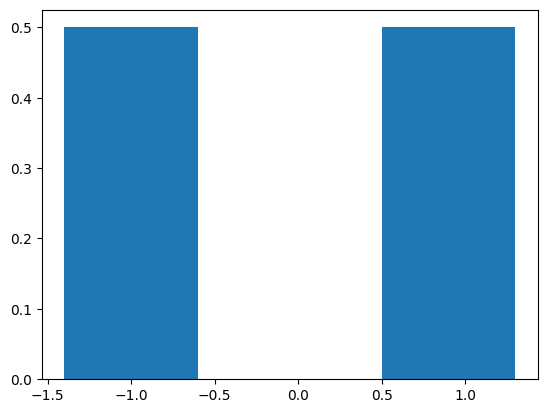

In [46]:
hist, bins_ = np.histogram(data,bins=20)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist/Ndata)

In [47]:
def linear_beta_schedule(steps, start=0.001, end=0.009):
    return np.linspace(start, end, steps)

def alpha_normaliced(step):
    return np.prod(1 - linear_beta_schedule(step))

def forward_process(data):

  noised_data = np.zeros(len(data))
  noise = np.zeros(len(data))

  for i in range(len(data)):

    time = np.random.randint(1000)
    noise[i] = np.random.normal(0,1)
    alpha = alpha_normaliced(time)
    noised_data[i] = data[i] * np.sqrt(alpha) + noise[i] * np.sqrt(1-alpha)

  return noised_data, noise

In [48]:
noised_data, noise = forward_process(data)

<BarContainer object of 200 artists>

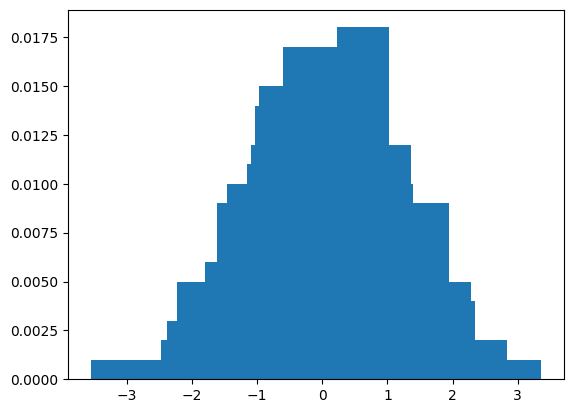

In [49]:
hist, bins_ = np.histogram(noised_data,bins=200)
fig, ax = plt.subplots()

ax.bar(bins_[:-1], hist/Ndata)

In [50]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def create_dataloader(data,target):

  data_tensor = torch.tensor(data, dtype=torch.float32).reshape(-1,1)
  target_tensor = torch.tensor(target, dtype=torch.float32).reshape(-1,1)

  data_ds = TensorDataset(data_tensor,target_tensor)
  data_dl = DataLoader(data_ds, batch_size=1, shuffle=True)

  return data_dl

def preprocessing(data, target):

  train_data_, test_data, train_target_, test_target = train_test_split(data, target, test_size=0.2)

  train_data, valid_data, train_target, valid_target = train_test_split(train_data_, train_target_, test_size=0.2)

  train_dl = create_dataloader(train_data, train_target)
  valid_dl = create_dataloader(valid_data, valid_target)
  test_dl = create_dataloader(test_data, test_target)

  return train_dl, valid_dl, test_dl


In [51]:
import torch.nn as nn

class Feed_forward(nn.Module):

  def __init__(self, input_size, output_size,n_hidden_layers,depht):
    super().__init__()

    #Setting input and output layers
    l = [0] * (2*n_hidden_layers + 2)
    l[0] = nn.Linear(input_size,depht)
    l[-1] = nn.Linear(depht,output_size)

    #Assembling hidden layers
    i = 1
    while i <= n_hidden_layers:
      l[i] = nn.Linear(depht,depht)
      l[i+1] = nn.ReLU()
      i+=2
    #    try:
    self.model_list = nn.ModuleList(l)

#        except:
#         print(l)

  def forward(self,x):
    for layer in self.model_list:
      x = layer(x)
    return x


In [52]:
def train(model,num_epochs,train_dl,valid_dl):

    loss_hist_train = np.zeros(num_epochs)
    loss_hist_valid = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        for x_batch, y_batch in train_dl:

          pred = model(x_batch)
          #Define loss function
          loss = loss_fn(pred, y_batch)
          #Backpropagation
          loss.backward()
          #Apply gradient to the weights
          optimizer.step()
          #Make gradients zero
          optimizer.zero_grad()
          loss_hist_train[epoch] += loss.item()*y_batch.size(0)

        for x_batch, y_batch in valid_dl:

          pred = model(x_batch)
          loss = loss_fn(pred, y_batch)

          loss_hist_valid[epoch] += loss.item()*y_batch.size(0)

        loss_hist_train[epoch] /= len(train_dl.dataset)

    return loss_hist_train, loss_hist_valid

In [54]:
model = Feed_forward(input_size=1,output_size=1,n_hidden_layers=1,depht=20)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()

In [43]:
train_dl, valid_dl, test_dl = preprocessing(noised_data,noise)

In [55]:
loss_hist_train,loss_hist_valid = train(model=model, num_epochs=10, train_dl=train_dl, valid_dl=valid_dl)

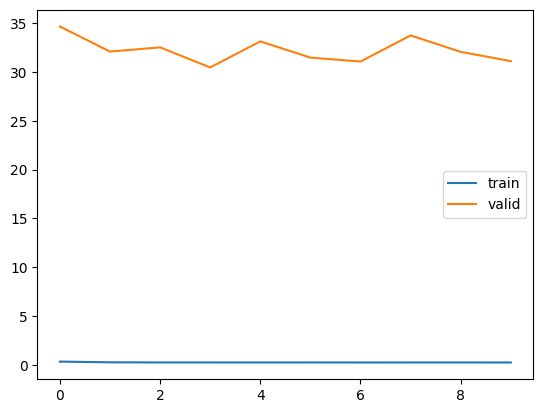

In [56]:
plt.plot(loss_hist_train,label='train')
plt.plot(loss_hist_valid,label='valid')
plt.legend()

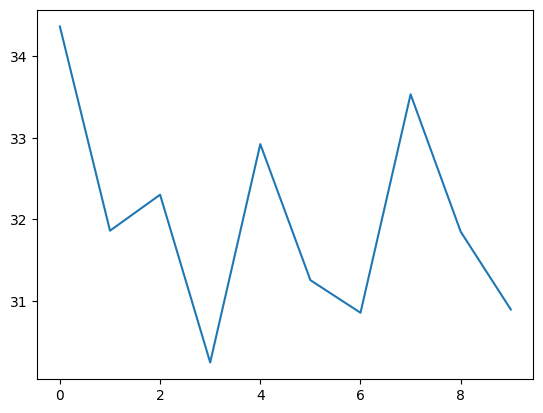

In [57]:
plt.plot(abs(loss_hist_train-loss_hist_valid))

<BarContainer object of 20 artists>

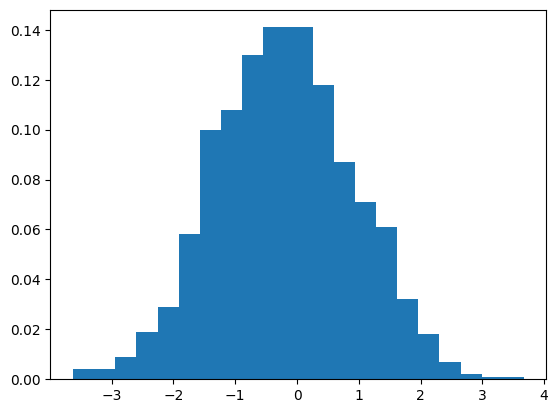

In [58]:
pure_noise = np.random.normal(0,1,1000)

hist_noise, bins_noise = np.histogram(pure_noise,bins=20)
fig, ax = plt.subplots()

ax.bar(bins_noise[:-1], hist_noise/Ndata)

In [77]:
T = 1000

beta_schedule = linear_beta_schedule(T)

distros = np.zeros((T,Ndata))

distros[0] = pure_noise

for t in range(1,T):

  previous_t = torch.tensor(distros[t-1],dtype=torch.float32).reshape(-1,1)

  beta = beta_schedule[t]
  alpha = 1 - beta
  alpha_normalic = alpha_normaliced(t)

  z = np.random.normal(loc=0,scale=beta,size=Ndata)

  deterministic_part = (previous_t - beta / np.sqrt(1 - alpha_normalic) * model(previous_t))

  deterministic_part_np = deterministic_part.detach().numpy()

  distros[t] = 1/np.sqrt(alpha)*deterministic_part_np + np.sqrt(beta) * z


ValueError: could not broadcast input array from shape (1000,1000) into shape (1000,)

RuntimeError: stack expects each tensor to be equal size, but got [1000, 2, 1] at entry 0 and [1000, 1] at entry 1

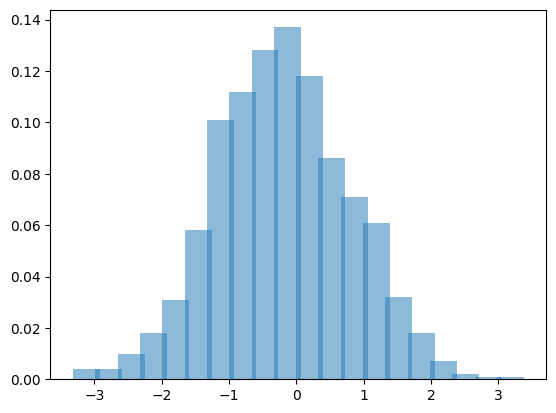

In [69]:
#from cycler import cycler

distributions = pure_noise



distributions = torch.tensor(distributions,dtype=torch.float32).reshape(-1,1)

fig, ax = plt.subplots()

temporal_evolution = distributions

for i in range(len(distributions)):

  beta = beta_schedule[i]
  alpha = 1 - beta
  alpha_normalic = alpha_normaliced(i+1)

  z = np.random.normal(loc=0,scale=beta_schedule[i],size=(1000,1))
  z = torch.tensor(z,dtype=torch.float32)

  deterministic_part = (distributions - beta / np.sqrt(1 - alpha_normalic) * model(distributions))

  distributions = 1/np.sqrt(alpha)*deterministic_part + np.sqrt(beta) * z

  if i % 100 == 0:

    hist_, bins_ = np.histogram(distributions.detach().numpy(),bins=20)

    ax.bar(bins_[:-1], hist_/Ndata,label=f'step {i}',alpha = 0.5,width=0.4)

ax.legend()

[1, 2, 3]

In [ ]:
# prompt: convert a torch tensor to numpy

# Assuming 'distributions' is your torch tensor
distributions_np = distributions.detach().numpy()
